In [ ]:
#!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

In [ ]:
# Step 1: Load the dataset
file_path = 'mfcc_features1.csv'  # Update with your file path if needed
df = pd.read_csv(file_path)

# Step 2: Analyze Class Imbalance
print("Class Distribution Before Balancing:")
print(df['label'].value_counts())

# Separate features and labels
X = df.iloc[:, :-1].values  # All columns except 'label'
y = df['label'].values

# Encode class labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 3: Balance the Dataset Using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y_encoded)

print("\nClass Distribution After Balancing:")
unique, counts = np.unique(y_balanced, return_counts=True)
print(dict(zip(label_encoder.inverse_transform(unique), counts)))

# Step 4: Normalize Features
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding for deep learning models
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)



Class Distribution Before Balancing:
label
cry           2372
hungry        1528
not_cry        864
silence        432
laugh          432
discomfort     108
tired           96
belly_pain      64
burping         32
Name: count, dtype: int64

Class Distribution After Balancing:
{'belly_pain': np.int64(2372), 'burping': np.int64(2372), 'cry': np.int64(2372), 'discomfort': np.int64(2372), 'hungry': np.int64(2372), 'laugh': np.int64(2372), 'not_cry': np.int64(2372), 'silence': np.int64(2372), 'tired': np.int64(2372)}


In [ ]:
# Step 6: Define Hyperparameter Tuning Function Using Keras Tuner
def build_model(hp):
    model = Sequential()

    # Input Layer with first Dense Layer (tunable units)
    model.add(Dense(units=hp.Int('units_input', min_value=128, max_value=512, step=64),
                    activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())  # Add Batch Normalization for stability
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.3, step=0.05)))

    # Additional Hidden Layers (tunable number of layers and units)
    for i in range(hp.Int('num_layers', min_value=2, max_value=4)):  # Increase layers for complexity
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=128, max_value=512, step=64), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.3, step=0.05)))

    # Output Layer
    model.add(Dense(y_train_onehot.shape[1], activation='softmax'))

    # Compile Model with AdamW optimizer (weight decay added)
    optimizer = AdamW(learning_rate=hp.Choice('learning_rate', [1e-4, 5e-4, 1e-3]), weight_decay=1e-4)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Step 7: Initialize Keras Tuner for Hyperparameter Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, # i change 20 to 5
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='audio_classification'
)

# Step 8: Perform Hyperparameter Search with Augmented Data and Callbacks
def add_noise(data, noise_factor=0.01):
    noise = noise_factor * np.random.normal(size=data.shape)
    return data + noise

X_train_augmented = add_noise(X_train)  # Augment training data with noise

tuner.search(X_train_augmented, y_train_onehot,
             validation_data=(X_test, y_test_onehot),
             epochs=25,  # i change 200 to 25
             callbacks=[
                 EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
             ],
             batch_size=32)

# Get the best hyperparameters and best model from the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"Input Units: {best_hps.get('units_input')}")
print(f"Dropout Input: {best_hps.get('dropout_input')}")
for i in range(best_hps.get('num_layers')):
    print(f"Units in Layer {i+1}: {best_hps.get(f'units_{i}')}")
    print(f"Dropout in Layer {i+1}: {best_hps.get(f'dropout_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Step 9: Train the Best Model on Full Training Data
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_augmented, y_train_onehot,
                         validation_data=(X_test, y_test_onehot),
                         epochs=20,
                         batch_size=32,
                         callbacks=[
                             EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
                         ])


Trial 6 Complete [00h 07m 56s]
val_accuracy: 0.788758784532547

Best val_accuracy So Far: 0.7981264591217041
Total elapsed time: 00h 51m 38s

Best Hyperparameters:
Input Units: 320
Dropout Input: 0.15000000000000002
Units in Layer 1: 128
Dropout in Layer 1: 0.25
Units in Layer 2: 448
Dropout in Layer 2: 0.1
Units in Layer 3: 128
Dropout in Layer 3: 0.1
Units in Layer 4: 128
Dropout in Layer 4: 0.1
Learning Rate: 0.001
Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5393 - loss: 1.2243 - val_accuracy: 0.7635 - val_loss: 0.5476 - learning_rate: 0.0010
Epoch 2/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7151 - loss: 0.6558 - val_accuracy: 0.7782 - val_loss: 0.4815 - learning_rate: 0.0010
Epoch 3/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7426 - loss: 0.5762 - val_accuracy: 0.7745 - val_loss: 0.4605 - learning_rate: 0.0010
Epoch 4/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7589 - loss: 0.5267 - val_accuracy: 0.7827 - val_los

In [ ]:
# Step 10: Evaluate the Model on Test Data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Step 11: Save the Best Model (Optional)
best_model.save('best_audio_classification_model.h5')
print("Best model saved as 'best_audio_classification_model.h5'.")



134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7977 - loss: 0.3953



Test Accuracy: 79.58%
Best model saved as 'best_audio_classification_model.h5'.


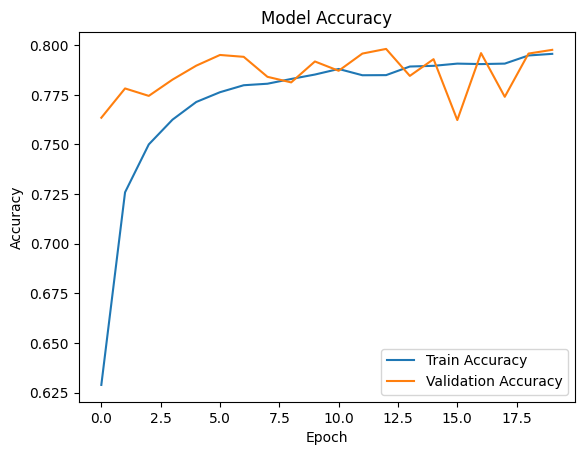

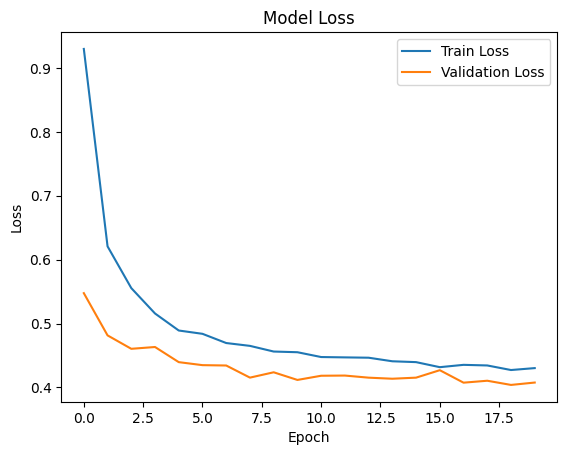

In [ ]:
# Step 12: Visualize Training History (Optional)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
